In [51]:
# Import packages
import os
import datetime
from datetime import date

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, r2_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from pandas.api.types import CategoricalDtype

%matplotlib inline
sns.set()  # Setting seaborn as default style even if use only matplotlib

# constants
audio_features_col_names = [
    "Danceability",
    "Energy",
    "Loudness",
    "Speechiness",
    "Acousticness",
    "Instrumentalness",
    "Valence",
]

# reading data
spotify_filepath = os.path.join(os.getcwd(), "spotify", "spotify.csv")
print(spotify_filepath)

# creating dataframe
spotify_data = pd.read_csv(spotify_filepath, delimiter=";")

spotify_data.drop(["Song URL"], axis=1, inplace=True, errors="ignore")  # drop url
# spotify_data.info()

# make "Date" column datetime type
spotify_data["Date"] = pd.to_datetime(spotify_data["Date"], dayfirst=True)
spotify_data.loc[0]["Date"]

# reverse dates
spotify_data = spotify_data.sort_values(by="Date")
# spotify_data.head()
# ranks are also reversed now...

# Scale the audio features.
spotify_data["Loudness"] = spotify_data["Loudness"].apply(lambda x: np.log10(np.abs(x)) / 60)
spotify_data

/home/jovyan/spotify/spotify.csv


,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id
651935,200,Ni**as In Paris,"JAY-Z, Kanye West",2017-01-01,0.757,0.882,0.063118,0.248,0.076,0.00,0.684,Artist 2,Kanye West,Nationality 2,United States,Anglo-America,1,1.000000,2KpCpk6HjXXLb7nnXoXA5O
651770,62,Sexual,"NEIKED, Dyo",2017-01-01,0.803,0.569,0.064479,0.074,0.062,0.00,0.809,Artist 1,NEIKED,Nationality 1,Sweden,Europe,139,70.000000,3AsAuGTaDQzavZZThyYlop
651769,61,"How Far I'll Go - From ""Moa""",Alessia Cara,2017-01-01,0.314,0.555,0.066372,0.370,0.157,0.00,0.159,Artist 1,Alessia Cara,Nationality 1,Canada,Anglo-America,140,140.000000,5hYTyyh2odQKphUbMqc5gN
651768,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,0.064873,0.117,0.057,0.00,0.392,Artist 2,Rihanna,Nationality 2,Barbados,Anglo-America,141,70.000000,11KJSRSgaDxqydKYiD2Jew
651767,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,0.064873,0.117,0.057,0.00,0.392,Artist 1,Drake,Nationality 1,Canada,Anglo-America,141,70.000000,11KJSRSgaDxqydKYiD2Jew
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,135,Can't Hold Us (feat. Ray Dalton),"Macklemore & Ryan Lewis, Macklemore, Ryan Lewi...",2023-05-29,0.633,0.927,0.060835,0.084,0.027,0.00,0.880,Artist 4,Ray Dalton,Nationality 4,United States,Anglo-America,66,16.500000,22skzmqfdWrjJylampe0kt
199,136,Cartão Black,"MC Caverinha, KayBlack, Wall Hein",2023-05-29,0.842,0.468,0.065551,0.637,0.255,0.00,0.547,Artist 1,MC Caverinha,Nationality 1,Brazil,Latin-America,65,21.666667,12YCtLHGk6tP6RbHDHflCs
200,136,Cartão Black,"MC Caverinha, KayBlack, Wall Hein",2023-05-29,0.842,0.468,0.065551,0.637,0.255,0.00,0.547,Artist 2,KayBlack,Nationality 2,Brazil,Latin-America,65,21.666667,12YCtLHGk6tP6RbHDHflCs
202,137,Apocalypse,Cigarettes After Sex,2023-05-29,0.369,0.467,0.065919,0.027,0.019,0.46,0.174,Artist 1,Cigarettes After Sex,Nationality 1,United States,Anglo-America,64,64.000000,3AVrVz5rK8Hrqo9YGiVGN5


In [2]:
# First make copy and drop irrelevant features
spotify_data_copy = spotify_data.copy(deep=True)
spotify_data_copy.drop(["Artists", '# of Artist', 'Artist (Ind.)', '# of Nationality', 'Continent',
                        'Points (Ind for each Artist/Nat)', 'Rank'], axis=1, inplace=True)

# group by song title and take average vlues
data_by_song_mean = spotify_data_copy.groupby("Title").mean(numeric_only=True)
data_by_song_mean


,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Points (Total)
Title,,,,,,,,
'98 Braves,0.488,0.670,0.062672,0.027,0.097,0.0,0.484,71.750000
!,0.725,0.543,0.063335,0.084,0.030,0.0,0.693,97.000000
#PROUDCATOWNERREMIX,0.783,0.522,0.063240,0.390,0.029,0.0,0.235,12.000000
$$$,0.774,0.507,0.064035,0.065,0.064,0.0,0.508,84.833333
$€ Freestyle,0.813,0.670,0.065626,0.335,0.200,0.0,0.380,125.000000
...,...,...,...,...,...,...,...,...
Î©. VIVRE UN PEU,0.416,0.528,0.066914,0.291,0.178,0.0,0.203,35.000000
ÎŸ. OG,0.576,0.446,0.066741,0.044,0.773,0.4,0.060,117.000000
İmdat,0.786,0.748,0.064650,0.162,0.267,0.0,0.562,72.562500


In [3]:
# create new dataframe with just data from 2022
#data_copy_2022 = spotify_data.copy(deep=True)
#data_copy_2022.sort_values("Date", ascending=True)
#data_copy_2022 = data_copy_2022.loc[(data_copy_2022["Date"] > pd.to_datetime('2021-12-31')) # delete all dates excluding 2022
#& (data_copy_2022["Date"] < pd.to_datetime('2023-1-1'))]

# dataset with one song per row and averaged feature values
#songs_2022 = data_copy_2022.groupby("Title").mean(numeric_only=True)
#songs_2022.drop(['Points (Total)', 'Rank', 'Points (Ind for each Artist/Nat)'], axis=1, inplace=True)
#songs_2022

# dataset with one song per day per row and total points
points_per_day = spotify_data.drop(audio_features_col_names + ['Artists', '# of Artist', 'Artist (Ind.)', 'Nationality', '# of Nationality', 'Continent', 'Points (Ind for each Artist/Nat)', 'id', 'Rank'], axis=1)

# split dataframe by date
points_by_date = {date: data for date, data in points_per_day.groupby('Date')}
# Now, points_by_date is a dictionary where the keys are dates and the values are the DataFrames for each date.
# Modify each date DataFrame to ensure no duplicate songs and random points for each song
for date, data in points_by_date.items():
    # Group by Song Title and select one random row for each song
    points_by_date[date] = data.groupby('Title', as_index=False).sample(n=1)
    
    # Reset the index of each grouped DataFrame
    points_by_date[date].reset_index(drop=True, inplace=True)
# To access the DataFrame for a specific date (for example, "2022-01-01"):
points_1 = points_by_date[pd.to_datetime('2022-01-01')]

# Now, we want to create a new DataFrame where:
# - Each row corresponds to a Song Title,
# - Each column corresponds to a Date,
# - Each entry represents the "Points" for that song on that date.

# We first concatenate all the DataFrames by date into a single DataFrame
points_concatenated = pd.concat(points_by_date.values(), ignore_index=True)

# Now we pivot the DataFrame to the required format
points_per_date_and_title = points_concatenated.pivot(index='Title', columns='Date', values='Points (Total)')
# convert NaN values to 0
points_per_date_and_title = points_per_date_and_title.fillna(0)
# add a total points accumulated column
#points_per_date_and_title['Total Points'] = points_per_date_and_title.sum(axis=1)
points_per_date_and_title


Date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2023-05-20,2023-05-21,2023-05-22,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29
Title,,,,,,,,,,,,,,,,,,,,,
'98 Braves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#PROUDCATOWNERREMIX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$$$,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$€ Freestyle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Î©. VIVRE UN PEU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ÎŸ. OG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
İmdat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# now create a dataframe where the rows are songs and columns are weekday and weekend

# Convert columns to datetime (if not already)
points_per_date_and_title.columns = pd.to_datetime(points_per_date_and_title.columns)

# Create two masks: one for weekdays (Monday to Friday), and one for weekends (Saturday and Sunday)
weekdays_mask = points_per_date_and_title.columns.weekday < 4  # Monday (0) to Thursday (3)
weekends_mask = ~weekdays_mask  # Friday (4), Saturday (5), and Sunday (6)

# Calculate average points for weekdays (Monday to Friday)
weekday_avg = points_per_date_and_title.loc[:, weekdays_mask].mean(axis=1)

# Calculate average points for weekends (Saturday and Sunday)
weekend_avg = points_per_date_and_title.loc[:, weekends_mask].mean(axis=1)

# Create a new DataFrame with song titles as rows and "weekday" and "weekend" columns
weekday_weekend = pd.DataFrame({
    'Title': points_per_date_and_title.index,
    'Weekday': weekday_avg,
    'Weekend': weekend_avg
})

weekday_weekend


,Title,Weekday,Weekend
Title,,,
'98 Braves,'98 Braves,0.032234,0.243513
!,!,0.000000,0.193613
#PROUDCATOWNERREMIX,#PROUDCATOWNERREMIX,0.000000,0.011976
$$$,$$$,0.462519,0.400200
$€ Freestyle,$€ Freestyle,0.000000,0.124750
...,...,...,...
Î©. VIVRE UN PEU,Î©. VIVRE UN PEU,0.026237,0.000000
ÎŸ. OG,ÎŸ. OG,0.087706,0.000000
İmdat,İmdat,0.505997,0.485030


In [5]:
weekday_weekend.describe()

,Weekday,Weekend
count,7457.000000,7457.000000
mean,2.693271,2.693473
std,6.890667,6.630486
min,0.000000,0.000000
25%,0.000000,0.074850
50%,0.202399,0.342315
75%,1.798351,1.864271
max,105.811844,103.377246


Observe that the values are similar in the 75 percentile.



In [6]:
weekday_weekend['difference'] = weekday_weekend['Weekday'] - weekday_weekend['Weekend']

weekday_greater = weekday_weekend[weekday_weekend['difference'] > 0]  # Songs where weekday > weekend
weekend_greater = weekday_weekend[weekday_weekend['difference'] < 0]  # Songs where weekend > weekday

#weekday_greater.describe()
weekend_greater.describe()



,Weekday,Weekend,difference
count,5200.000000,5200.000000,5200.000000
mean,1.324997,1.518717,-0.193720
std,4.066047,4.184374,0.356405
min,0.000000,0.000998,-7.591586
25%,0.000000,0.069860,-0.205343
50%,0.044228,0.232036,-0.109864
75%,0.537856,0.783433,-0.050898
max,97.401049,97.665669,-0.000081


In [7]:
# Define the new 'weekday > weekend' column based on the conditions
#weekday_weekend['Weekday > Weekend'] = np.where(
#    (weekday_weekend['Weekday'] > weekday_weekend['Weekend']) & (abs(weekday_weekend['Weekday'] - weekday_weekend['Weekend']) > 0.459384), 1,
#    np.where(
#        (weekday_weekend['Weekend'] > weekday_weekend['Weekday']) & (abs(weekday_weekend['Weekend'] - weekday_weekend['Weekday']) > 0.204730), 0, 2
#    )
#)



In [8]:
# Define the new 'weekday > weekend' column based on the conditions
weekday_weekend['Weekday > Weekend'] = np.where(
    (weekday_weekend['Weekday'] > weekday_weekend['Weekend']) , 1, 0
)


In [9]:
# drop all 2's
weekday_weekend = weekday_weekend[weekday_weekend['Weekday > Weekend'] != 2].drop(['Weekend','Weekday','difference'],axis=1)
weekday_weekend

,Title,Weekday > Weekend
Title,,
'98 Braves,'98 Braves,0
!,!,0
#PROUDCATOWNERREMIX,#PROUDCATOWNERREMIX,0
$$$,$$$,1
$€ Freestyle,$€ Freestyle,0
...,...,...
Î©. VIVRE UN PEU,Î©. VIVRE UN PEU,1
ÎŸ. OG,ÎŸ. OG,1
İmdat,İmdat,1


In [10]:
data_by_song_mean

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Points (Total)
Title,,,,,,,,
'98 Braves,0.488,0.670,0.062672,0.027,0.097,0.0,0.484,71.750000
!,0.725,0.543,0.063335,0.084,0.030,0.0,0.693,97.000000
#PROUDCATOWNERREMIX,0.783,0.522,0.063240,0.390,0.029,0.0,0.235,12.000000
$$$,0.774,0.507,0.064035,0.065,0.064,0.0,0.508,84.833333
$€ Freestyle,0.813,0.670,0.065626,0.335,0.200,0.0,0.380,125.000000
...,...,...,...,...,...,...,...,...
Î©. VIVRE UN PEU,0.416,0.528,0.066914,0.291,0.178,0.0,0.203,35.000000
ÎŸ. OG,0.576,0.446,0.066741,0.044,0.773,0.4,0.060,117.000000
İmdat,0.786,0.748,0.064650,0.162,0.267,0.0,0.562,72.562500


In [11]:
# Merge the two DataFrames on the song title (index)
songs_features_weekday = data_by_song_mean.join(weekday_weekend, how='inner')
songs_features_weekday = songs_features_weekday.drop(['Points (Total)', 'Title'], axis=1)
songs_features_weekday

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Weekday > Weekend
Title,,,,,,,,
'98 Braves,0.488,0.670,0.062672,0.027,0.097,0.0,0.484,0
!,0.725,0.543,0.063335,0.084,0.030,0.0,0.693,0
#PROUDCATOWNERREMIX,0.783,0.522,0.063240,0.390,0.029,0.0,0.235,0
$$$,0.774,0.507,0.064035,0.065,0.064,0.0,0.508,1
$€ Freestyle,0.813,0.670,0.065626,0.335,0.200,0.0,0.380,0
...,...,...,...,...,...,...,...,...
Î©. VIVRE UN PEU,0.416,0.528,0.066914,0.291,0.178,0.0,0.203,1
ÎŸ. OG,0.576,0.446,0.066741,0.044,0.773,0.4,0.060,1
İmdat,0.786,0.748,0.064650,0.162,0.267,0.0,0.562,1


In [12]:
# Problem: some values of loudness (3) are negative
# Filter rows with any negative values
negative_rows = songs_features_weekday[(songs_features_weekday < 0).any(axis=1)]

# Print the filtered rows
print(negative_rows)

# Solution: set them to 0
songs_features_weekday[songs_features_weekday < 0] = 0

                                                    Danceability    Energy  \
Title                                                                        
Agora Vai Sentar                                        0.814000  0.653000   
Desde Esa Noche (feat. Maluma)                          0.780000  0.929000   
Girls                                                   0.570000  0.974000   
Go                                                      0.755000  0.898000   
Good Drank                                              0.836000  0.776000   
It's A Raid (feat. Post Malone)                         0.472000  0.996000   
Live It Up - Official Song 2018 FIFA World Cup ...      0.582000  0.944000   
Murder In My Mind                                       0.712000  0.972000   
PUNTO 40                                                0.861459  0.828164   
Puta Mexica                                             0.853000  0.913000   
Sal y Perrea                                            0.786000

Visualisation

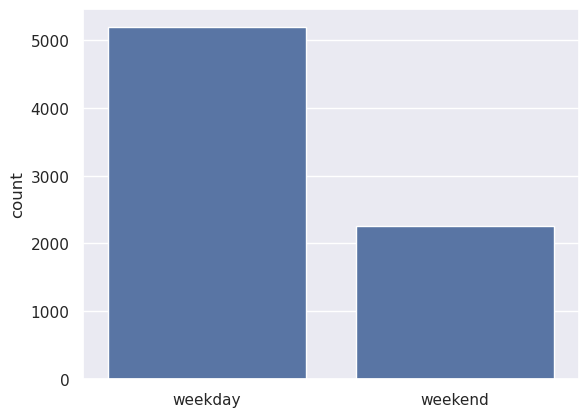

In [20]:
# number of songs more populat on weekdays vs weekends
ax = sns.countplot(x='Weekday > Weekend', data=songs_features_weekday)
ax.set_xticks([0, 1]) # what does this do exactly?
ax.set_xticklabels(['weekday', 'weekend'])
plt.xlabel('') # removes "is-span" label from x axis
plt.show()

In [22]:
# now try Naive Bayes on this dataset
X = songs_features_weekday.drop('Weekday > Weekend', axis=1)
y = songs_features_weekday['Weekday > Weekend']

#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

# 'string {}'.format(x) prints the string + x in the {} position
print('Number of songs more popular on weekdays: {}'.format((y==1).sum())) #summing all entries of y which is equal to 1
print('Number of songs more popular on weekends: {}'.format((y==0).sum()))


Number of songs more popular on weekdays: 2257
Number of songs more popular on weekends: 5200


In [27]:
# Your Code goes here:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

print('y_test shape: {}'.format(y_test.shape))

X_train shape: (6711, 7)
y_train shape: (6711,)
X_test shape: (746, 7)
y_test shape: (746,)


Naive Bayes - also want to find what features are most relevant

In [31]:
gnb = GaussianNB()
gnb.fit(X=X_train, y=y_train)

GaussianNB()

In [32]:
tr_pred = gnb.predict(X=X)

ca = accuracy_score(y, gnb.predict(X)) # or ca = gnb.score(X,y)
print('Training set accuracy: {:.2f}%'.format(ca*100))

tr_pred = gnb.predict(X=X_test)

ca_2 = accuracy_score(y_test, gnb.predict(X_test)) # or ca = gnb.score(X,y)
print('Test set accuracy: {:.2f}%'.format(ca_2*100))


Training set accuracy: 69.05%
Test set accuracy: 69.30%


Try including friday to weekends = around 5 % increase. Try different way of classifying :maybe average isnt accurate.

For example, take mean(abs(weekday-weekend)) then say a song is more popular on weekday/weekend only if difference is greater than the mean difference = around 5 more % increase.

Now try comparing weekdays vs weekend for each week then compare cumulative points.

Logistic Regression

In [33]:
# Your Code goes here:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
print('Classification accuracy on training set: {:.3f}'.format(lr.score(X, y)))
print('Classification accuracy on test set: {:.3f}'.format(lr.score(X_test, y_test)))

Classification accuracy on training set: 0.697
Classification accuracy on test set: 0.696


In [34]:
# Your Code goes here:
weight = lr.coef_
bias = lr.intercept_
print('Weight of the Logistic Regression classifier: {}'.format(weight))
print('Bias of the Logistic Regression classifier: {}'.format(bias))

Weight of the Logistic Regression classifier: [[-0.29817152 -0.77945553  0.06123656 -1.84536059 -0.4186474  -0.52556951
  -0.17817538]]
Bias of the Logistic Regression classifier: [0.28039741]


KNN

In [38]:
# Your Code goes here:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print('KNN classification (k=1) accuracy on training set: {:.3f}'.format(knn.score(X_train, y_train)))
print('KNN classification (k=1) accuracy on test set: {:.3f}'.format(knn.score(X_test, y_test)))

KNN classification (k=1) accuracy on training set: 0.999
KNN classification (k=1) accuracy on test set: 0.597


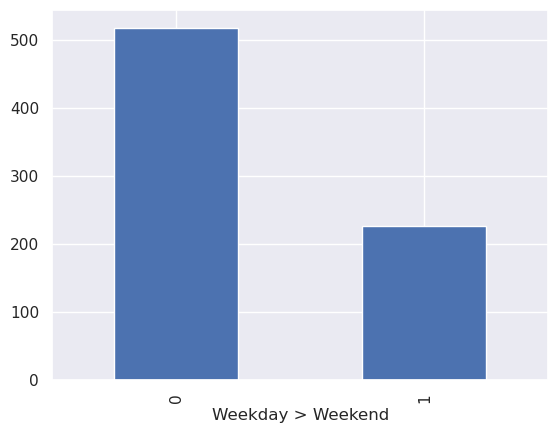

In [39]:
# Your Code goes here: 
class_counts = y_test.value_counts()
ax = class_counts.plot(kind="bar")

In [41]:
# baseline classifier (0) accuracy
print('The baseline classifier (predict always 0) would achieve a classification accuracy score of: {:.3f}'.
      format(class_counts[0] / class_counts.values.sum()))

The baseline classifier (predict always 0) would achieve a classification accuracy score of: 0.696


In [42]:
# Exploring the affect of the k parameter
k_list = [1, 3, 5, 7, 10, 30, 50, 100, 200]
ca = []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    score = knn.score(X_test,y_test)
    ca.append(score)
    print('Performance on test with {} nearest neighbours: {:.3f}'.format(k, score))

Performance on test with 1 nearest neighbours: 0.597
Performance on test with 3 nearest neighbours: 0.633
Performance on test with 5 nearest neighbours: 0.649
Performance on test with 7 nearest neighbours: 0.661
Performance on test with 10 nearest neighbours: 0.685
Performance on test with 30 nearest neighbours: 0.705
Performance on test with 50 nearest neighbours: 0.700
Performance on test with 100 nearest neighbours: 0.694
Performance on test with 200 nearest neighbours: 0.696


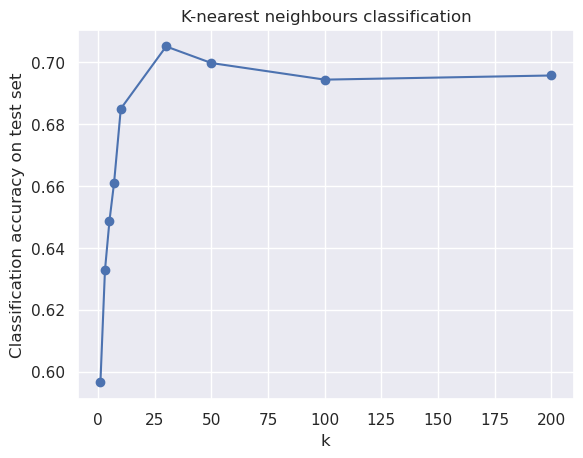

In [43]:
# plotting
plt.scatter(k_list, ca)
plt.plot(k_list,ca, )
plt.xlabel('k')
plt.ylabel('Classification accuracy on test set')
plt.title('K-nearest neighbours classification')
plt.show()

In [45]:
# confusion matrix for best value of k
knn = KNeighborsClassifier(n_neighbors=30).fit(X_train, y_train)
pred = knn.predict(X_test)
cm = confusion_matrix(y_test, pred)
cm

array([[516,   3],
       [217,  10]])

In [46]:
# normalising the confusion matrix:
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
cm_norm
## Confusion matrix has values c_ij such that true label i is predicted as label j, i.e. rows should sum to 1

array([[0.99421965, 0.00578035],
       [0.95594714, 0.04405286]])

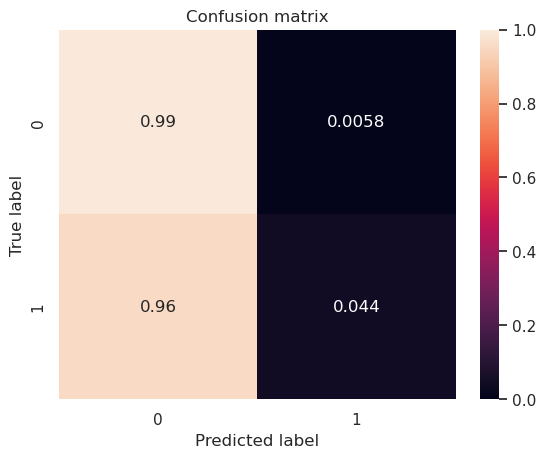

In [47]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
plot_confusion_matrix(cm_norm, classes=knn.classes_)

Performance on test with  1  nearest neighbours:  14.543082667726894
Performance on test with  3  nearest neighbours:  4.951350334174321
Performance on test with  5  nearest neighbours:  2.0548244426904403
Performance on test with  7  nearest neighbours:  1.3572084146826349
Performance on test with  10  nearest neighbours:  0.9421610841639784
Performance on test with  30  nearest neighbours:  0.6023877428595791
Performance on test with  50  nearest neighbours:  0.5959798157118084
Performance on test with  100  nearest neighbours:  0.591887267437633
Performance on test with  200  nearest neighbours:  0.59312799601812


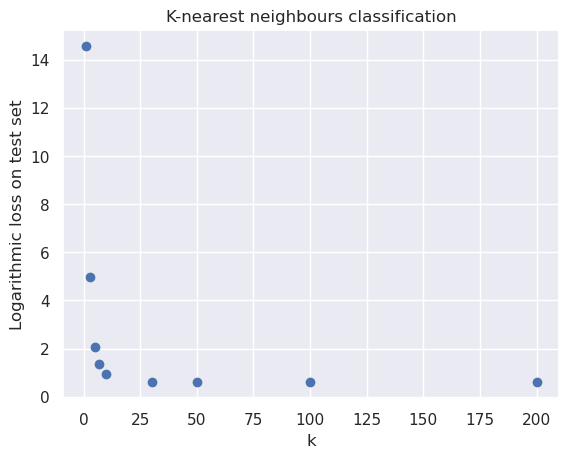

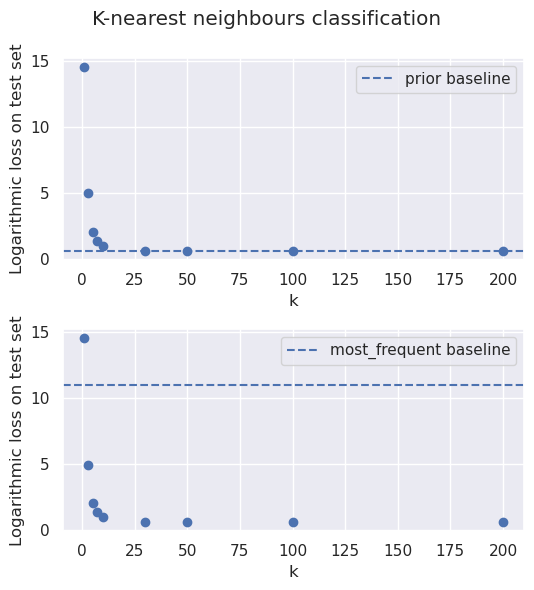

In [48]:
# Your Code goes here:
k_list = [1, 3, 5, 7, 10, 30, 50, 100, 200]
logloss = []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    pred_proba = knn.predict_proba(X_test)
    this_logloss = log_loss(y_test, pred_proba)
    logloss.append(this_logloss)
    print('Performance on test with ', k, ' nearest neighbours: ', this_logloss)
plt.scatter(k_list, logloss)
plt.xlabel('k')
plt.ylabel('Logarithmic loss on test set')
plt.title('K-nearest neighbours classification')

# Extension - plot baselines too
baselines = ['prior', 'most_frequent']
fig, ax = plt.subplots(len(baselines), 1, figsize=(5.5,6))
from sklearn.dummy import DummyClassifier
bl_loss = {}
for ii, baseline in enumerate(baselines):
    plt.sca(ax[ii])
    dummy_classifier = DummyClassifier(strategy=baseline).fit(X_train, y_train)
    pred_proba = dummy_classifier.predict_proba(X_test)
    this_logloss = log_loss(y_test, pred_proba)
    plt.scatter(k_list, logloss)
    plt.axhline(this_logloss, label='{} baseline'.format(baseline), linestyle='--')
    plt.xlabel('k')
    plt.ylabel('Logarithmic loss on test set')
    plt.legend()

plt.suptitle('K-nearest neighbours classification')
plt.tight_layout()
plt.subplots_adjust(top=.9)
plt.show()

Decision Trees


In [49]:
# Your Code goes here:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1000)
dt.fit(X_train.astype(float), y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1000)

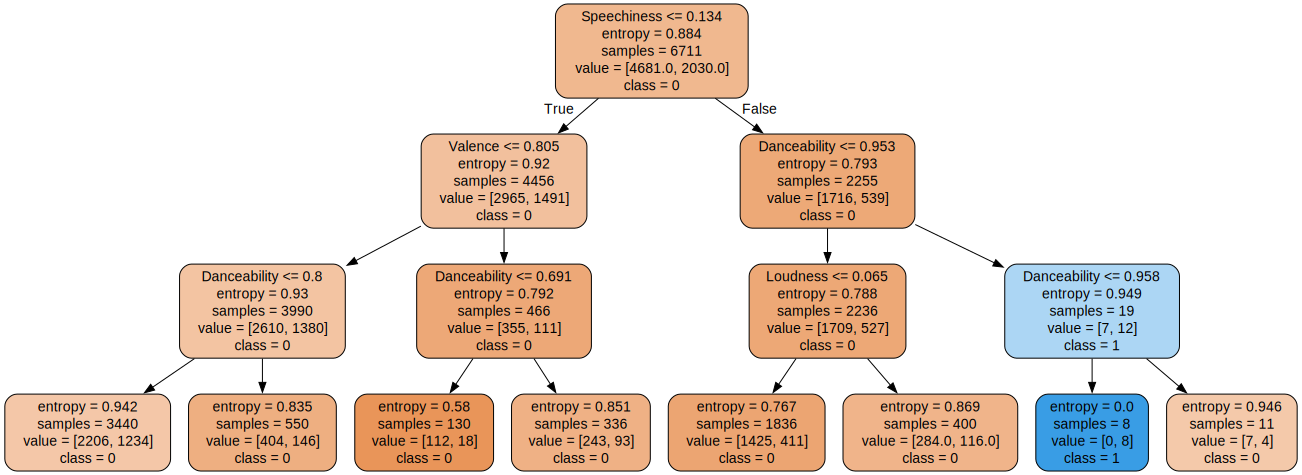

In [52]:
dot_data = export_graphviz(dt, out_file=None, 
    feature_names=X_train.columns,  
    class_names=['0', '1'],  
    filled=True, rounded=True,  
    special_characters=False)
graph = graphviz.Source(dot_data)
graph

In [53]:
column_names = X_train.columns
with open("tree.dot", 'w') as f:
    f = export_graphviz(dt, out_file=f,
                        feature_names=column_names,  
                        class_names=['0', '1'],  
                        filled=True, rounded=True,  
                        special_characters=False)

In [54]:
# Your Code goes here:
for i, column in enumerate(column_names):
    if dt.feature_importances_[i] > 0:
        print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))

Importance of feature Danceability:, 0.356
Importance of feature Loudness:, 0.051
Importance of feature Speechiness:, 0.441
Importance of feature Valence:, 0.152


In [55]:
# Your Code goes here:
prediction_train = dt.predict(X=X_train)
prediction_test = dt.predict(X=X_test)
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_train,prediction_train)))
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test)))

Classification accuracy on training set: 0.699
Classification accuracy on test set: 0.694


In [56]:
# Anoter decision tree but this time without restriction, full depth
dt_fulldepth = DecisionTreeClassifier(criterion='entropy', random_state=1000)
dt_fulldepth.fit(X_train, y_train)
prediction_train2 = dt_fulldepth.predict(X=X_train)
prediction_test2 = dt_fulldepth.predict(X=X_test)
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_train,prediction_train2)))
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test2)))

Classification accuracy on training set: 0.998
Classification accuracy on test set: 0.574


In [58]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

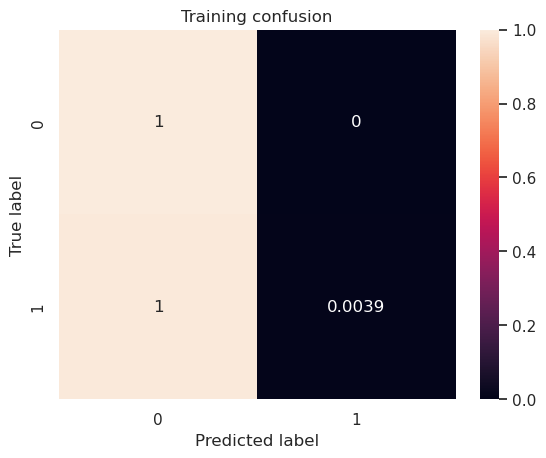

In [59]:
# Normalised Data

# Your Code goes here:
cm = confusion_matrix(y_train, prediction_train)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Training confusion')

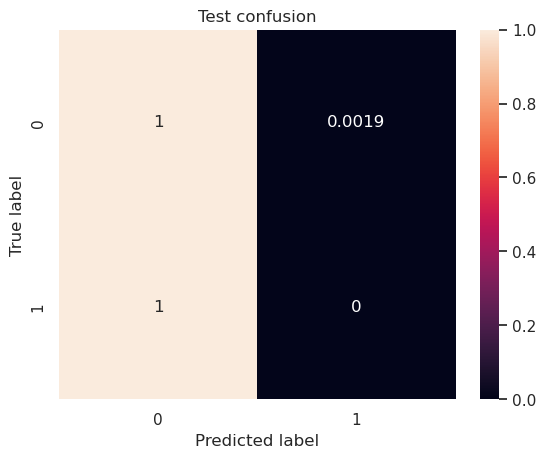

In [60]:
# Validation Data

# Your Code goes here:
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Test confusion')

Random Forest

Classification accuracy on test set: 0.698


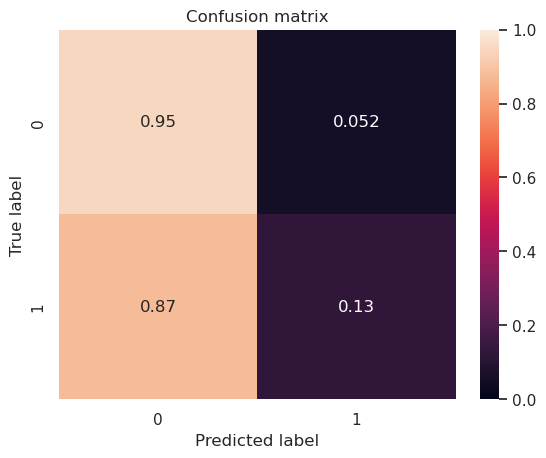

In [61]:
# Your Code goes here:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
prediction_test = rf.predict(X=X_test)
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test)))
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)


Classification accuracy on test set with max features = 1 and max_depth = None: 0.700
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.696
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.696
Classification accuracy on test set with max features = 1 and max_depth = 10: 0.696
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.708
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.696
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.696
Classification accuracy on test set with max features = sqrt and max_depth = 10: 0.693
Classification accuracy on test set with max features = log2 and max_depth = None: 0.708
Classification accuracy on test set with max features = log2 and max_depth = 2: 0.696
Classification accuracy on test set with max features = log2 and max_depth = 5: 0.696
Classification accuracy on test set with max features =

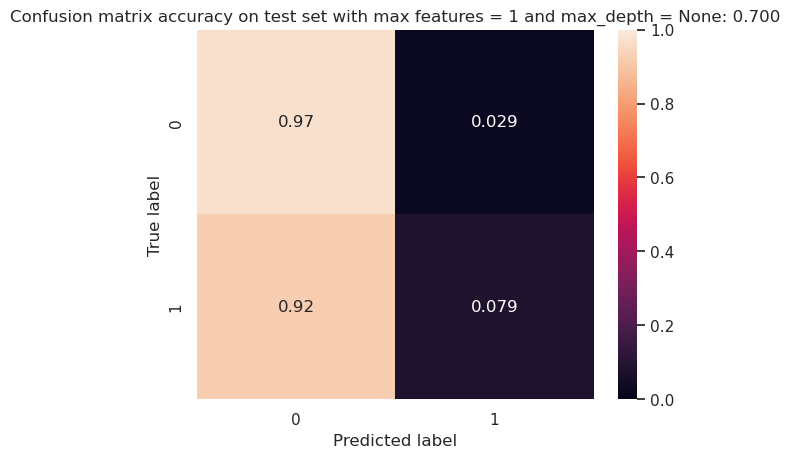

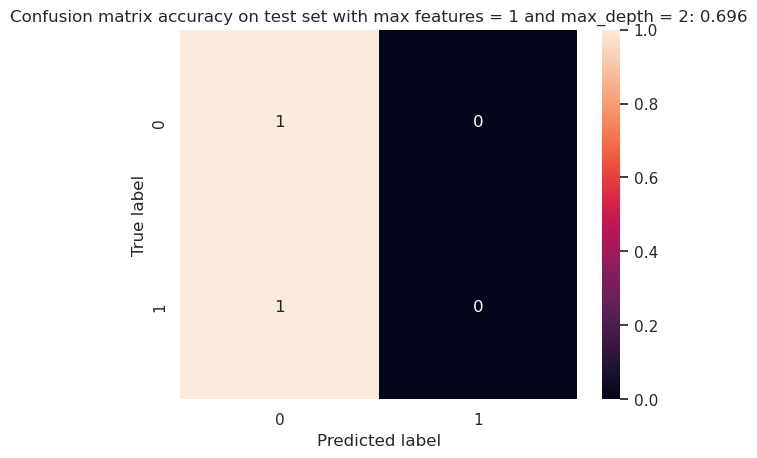

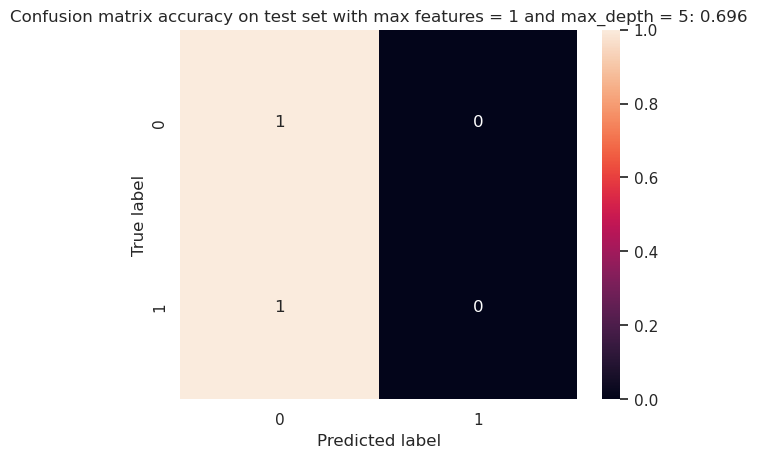

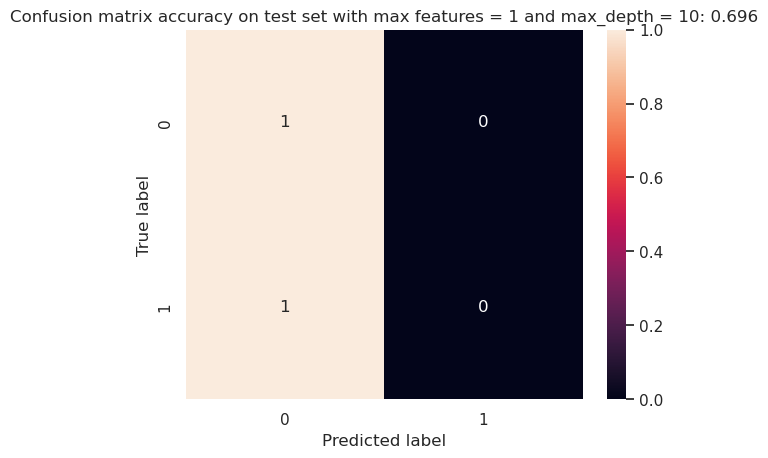

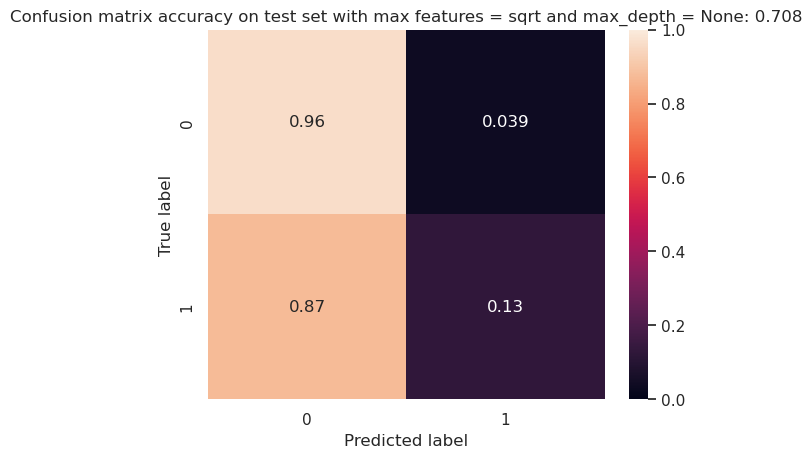

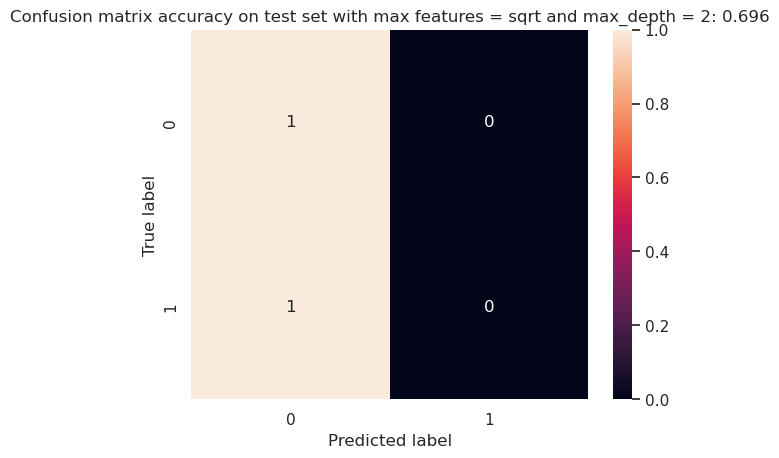

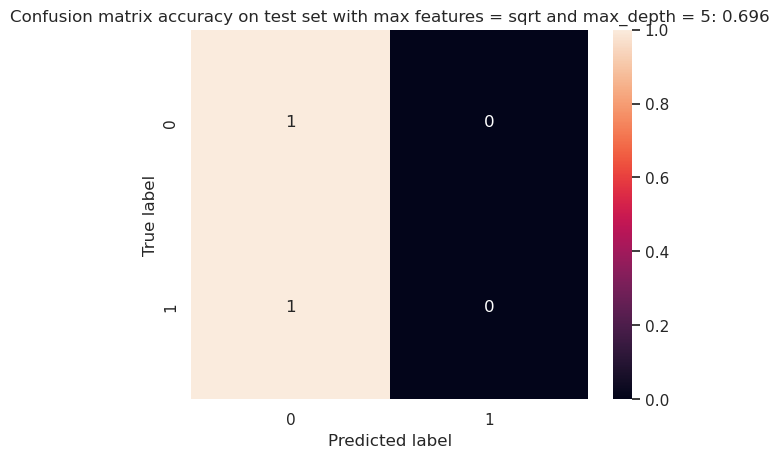

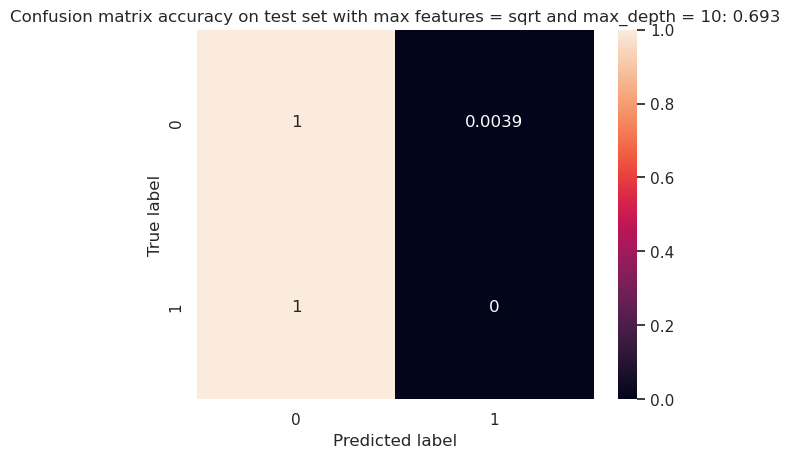

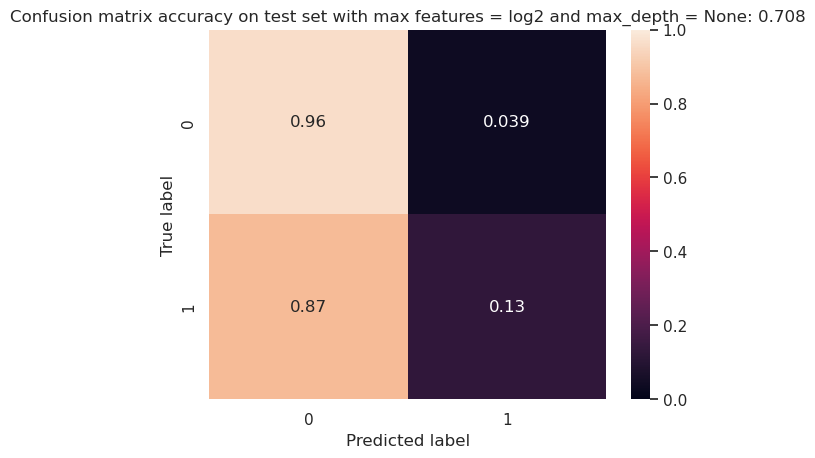

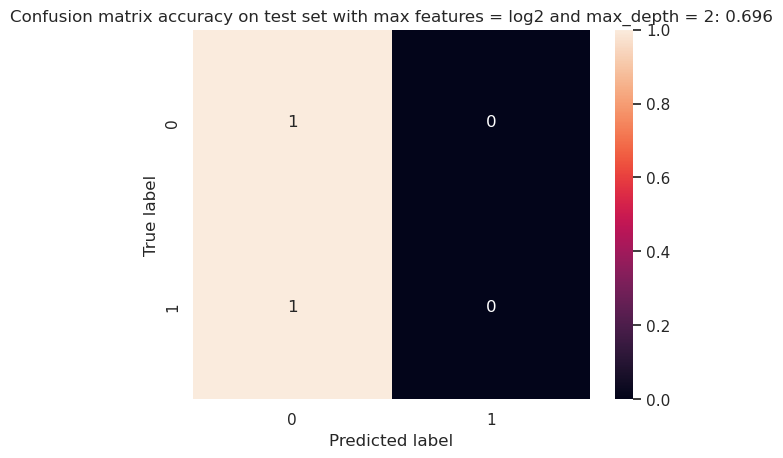

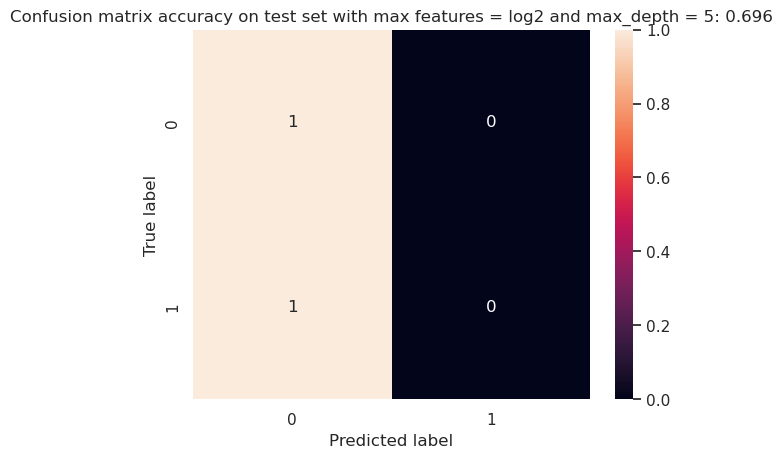

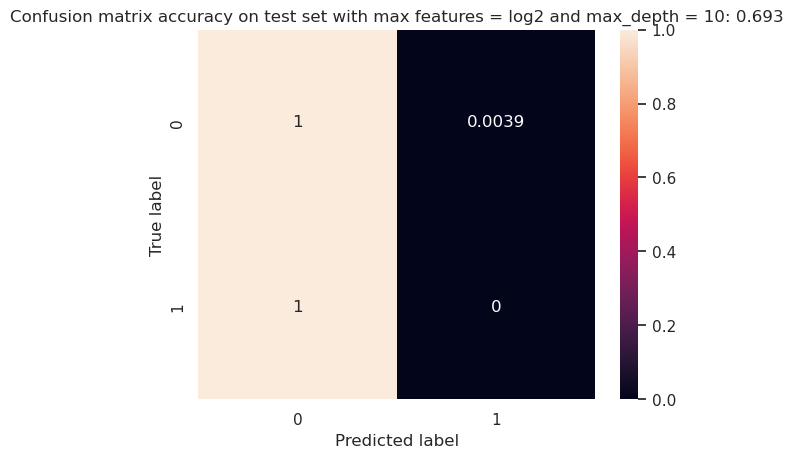

In [62]:
# How high can you get the performance of the classifier by changing the max depth of the trees (max_depth), or the max_features parameters? Try a few values just to get a look. Don't do a grid search or anything in-depth, just get a feel. Try the same settings twice...do you get the same accuracy?
from itertools import product
n_estimators = 500
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 5, 10]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_, title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))

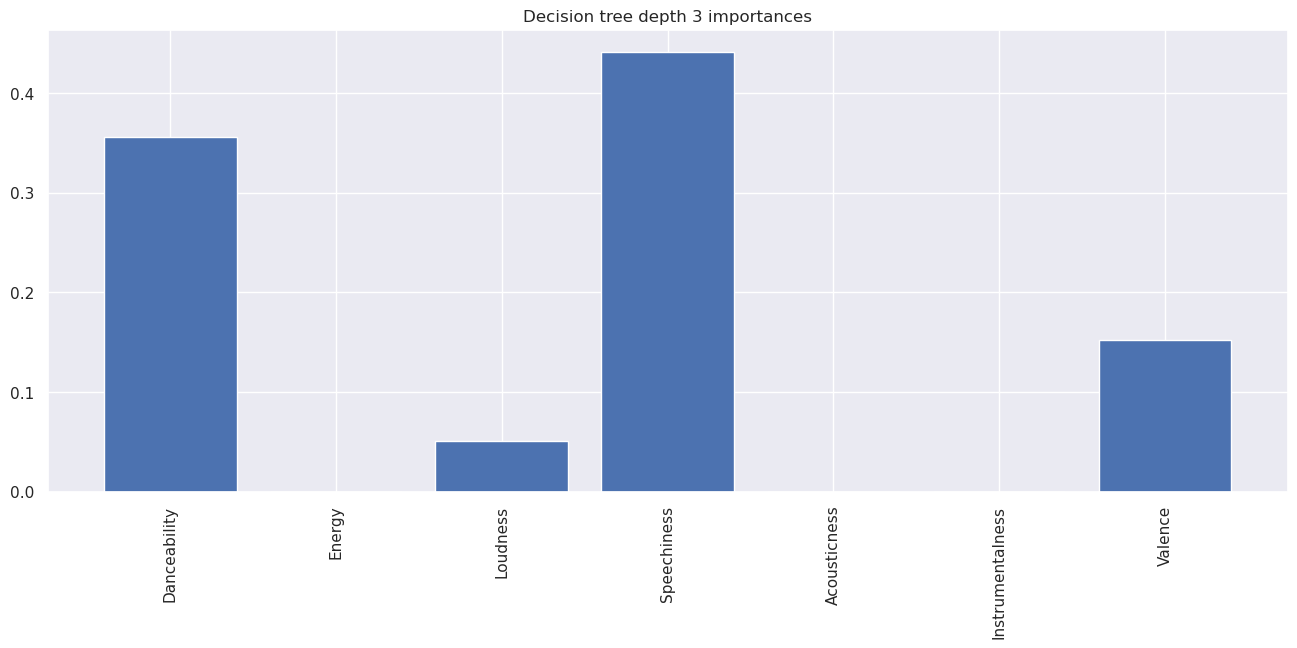

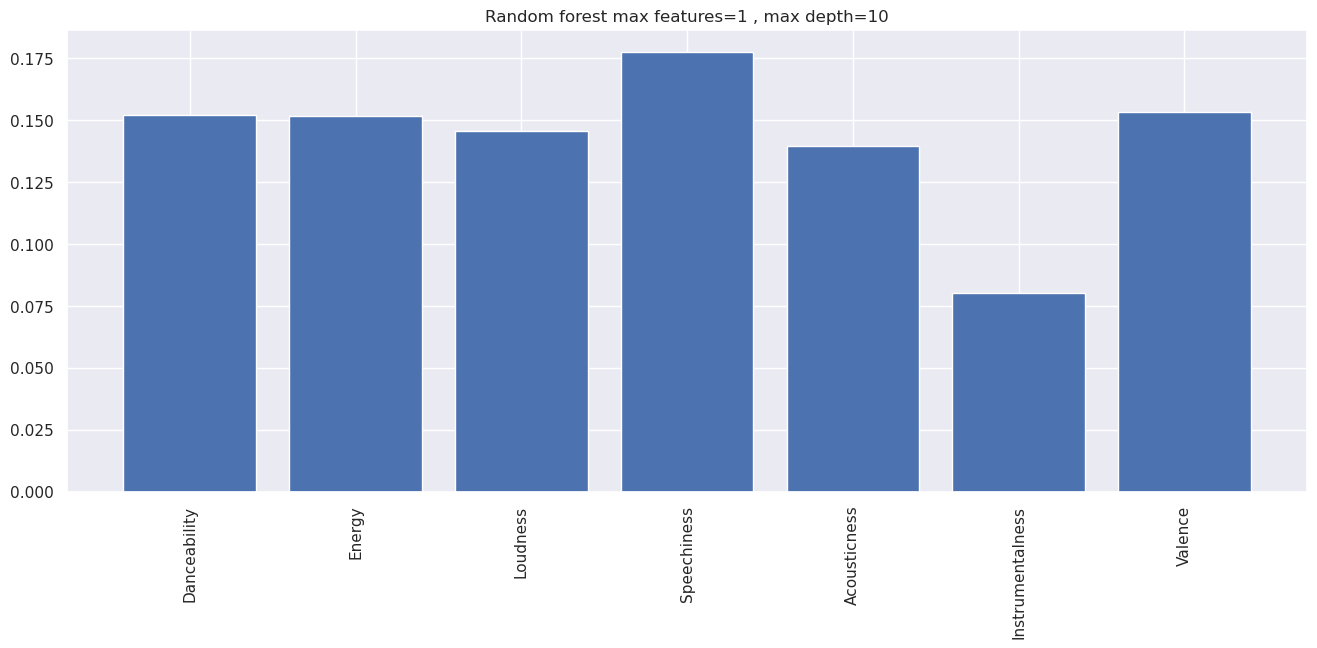

Importance of feature Danceability, DT: 0.356, RF: 0.152
Importance of feature Energy, DT: 0.000, RF: 0.152
Importance of feature Loudness, DT: 0.051, RF: 0.145
Importance of feature Speechiness, DT: 0.441, RF: 0.178
Importance of feature Acousticness, DT: 0.000, RF: 0.140
Importance of feature Instrumentalness, DT: 0.000, RF: 0.080
Importance of feature Valence, DT: 0.152, RF: 0.153


In [63]:
# Compare the feature importances as estimated with the decision tree and random forest classifiers.
rf = RandomForestClassifier(n_estimators=500, 
                            criterion='entropy', 
                            max_features=1, 
                            max_depth=10, 
                            n_jobs=2)
rf.fit(X_train, y_train)
_, ax1 = plt.subplots(1, 1, figsize=(16,6))
xx = np.arange(len(dt.feature_importances_))
ax1.bar(xx, dt.feature_importances_)
ax1.set_xticks(xx)
ax1.set_xticklabels(column_names, rotation='vertical')
ax1.set_title('Decision tree depth 3 importances')
plt.show()

_, ax2 = plt.subplots(1, 1, figsize=(16,6))
ax2.bar(xx, rf.feature_importances_)
ax2.set_xticks(xx)
ax2.set_xticklabels(column_names, rotation='vertical')
ax2.set_title('Random forest max features=1 , max depth=10')
plt.show()

for i, column in enumerate(column_names):
    if dt.feature_importances_[i] > 0 or rf.feature_importances_[i]:
        print('Importance of feature {}, DT: {:.3f}, RF: {:.3f}'.format(column, dt.feature_importances_[i], rf.feature_importances_[i]))